In this notebook, I'm working with building a Sentiment Classifier Based on the Tweet Sentiment Extraction Dataset.

Objective is to conduct an analysis of the dataset, perform text data vectorization using bag-of-words and TF-IDF methods, compare them, build a classifier, and conduct error analysis.

The data is sourced from this competition on Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Task 1: Loading and Exploring the Dataset Download the train.csv dataset from the link and familiarize with its structure. I display the first 5 rows and the main statistics: number of records, column types, and number of missing values. Remove the records with missing values.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [5]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [6]:
df_cleaned = df.dropna()

In [7]:
df_cleaned.shape[0]

27480

**Exploratory Data Analysis**

Now I conduct an analysis of the number of classes and the distribution of labels. The classes are located in the "sentiment" column. I visualize the distribution of text lengths in characters and draw conclusions about the lengths of the posts.



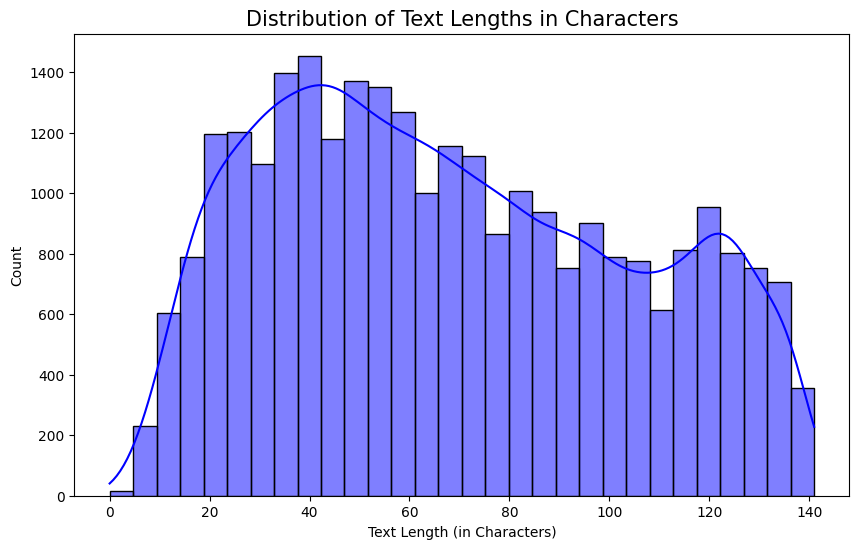


Basic Statistics for Text Lengths:
count    27481.000000
mean        68.327535
std         35.605608
min          0.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df['text'] = df['text'].fillna('')

df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths in Characters', fontsize=15)
plt.xlabel('Text Length (in Characters)')
plt.ylabel('Count')
plt.show()

print("\nBasic Statistics for Text Lengths:")
print(df['text_length'].describe())

The longest text contains 141 characters. Most posts have a short length—ranging from 39 to 97 characters, with a median of 64 characters. A significant portion of the texts is relatively short, but some posts may be empty (with a length of 0 characters), which requires further analysis and processing.

**Preprocessing Text Data and Vectorization with Bag of Words**

My goal here is to obtain vectors using the bag of words method from the text column, performing text preprocessing first. The preprocessing will include:

- Removal of stopwords in the required language.
- Tokenization (splitting texts into fragments of 1 word).
- Stemming words using SnowballStemmer.

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords (assuming the language of the texts is English; change for other languages)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # If the text is in Ukrainian, change to 'ukrainian'

# Initialize the stemmer
stemmer = SnowballStemmer('english')  # If the text is in Ukrainian, change to 'russian'

# Function for cleaning the text
def preprocess_text(text):
    # 1. Convert the text to lowercase
    text = text.lower()

    # 2. Remove unwanted characters, keeping only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Tokenization (splitting into words)
    tokens = text.split()

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to each text
df['cleaned_text'] = df['text'].fillna('').apply(preprocess_text)

# Check the cleaned texts
print(df['cleaned_text'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                            id respond go
1                  sooo sad miss san diego
2                               boss bulli
3                      interview leav alon
4    son couldnt put releas alreadi bought
Name: cleaned_text, dtype: object


In [10]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # Set the dictionary size (5000 words)

# Apply vectorization to the cleaned texts
X = vectorizer.fit_transform(df['cleaned_text'])

# Output the first 5 vectorized texts
print(X.toarray()[:5])

# Print the dimensions of the matrix after vectorization
print(f"Matrix shape after vectorization: {X.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Matrix shape after vectorization: (27481, 5000)


**Building a Classifier**

Next I will split the data indices into training and testing sets in the chosen ratio. Using the obtained indices, form the sets for training the classifier: X_train_bow, X_test_bow, y_train, and y_test.

I will train a classifier on the data vectorized using the bag-of-words method.



In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Form X and y (feature matrix and target variable)
X = X  # this is the result of vectorization from the previous stage (bag of words)
y = df['sentiment']  # Target variable - classes

# Split the data into training and testing sets (80% training, 20% testing)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Try several models:
# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bow, y_train)
y_pred_log_reg = log_reg.predict(X_test_bow)

# 2. Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_bow, y_train)
y_pred_tree = tree.predict(X_test_bow)

# 3. Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_bow, y_train)
y_pred_gb = gb_clf.predict(X_test_bow)

# Evaluate classification quality for each model
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

# Evaluate each model
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")


--- Logistic Regression ---
Accuracy: 0.6815
Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.62      0.66      1562
     neutral       0.63      0.70      0.67      2230
    positive       0.74      0.71      0.72      1705

    accuracy                           0.68      5497
   macro avg       0.69      0.68      0.68      5497
weighted avg       0.69      0.68      0.68      5497

Confusion Matrix:
[[ 972  479  111]
 [ 346 1570  314]
 [  69  432 1204]]


--- Decision Tree ---
Accuracy: 0.6449
Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.66      0.63      1562
     neutral       0.65      0.57      0.61      2230
    positive       0.68      0.72      0.70      1705

    accuracy                           0.64      5497
   macro avg       0.64      0.65      0.65      5497
weighted avg       0.65      0.64      0.64      5497

Confusion Matrix:
[[1030  375  15

The best model is Logistic Regression, which shows the highest overall accuracy and the most balanced results across all classes.

Gradient Boosting performs well with neutral posts but struggles with classifying negative ones. The Decision Tree demonstrates the lowest accuracy among all the models.

Logistic Regression is the most effective model for this dataset, but additional data processing techniques or different models could be explored to improve accuracy.

**Analyzing the Importance of Words in the Selected Classifier**

For the chosen model I'll conduct an analysis of word importance (features): which words (tokens) have the most influence on determining sentiment?

In [12]:
import numpy as np

# Get words (tokens) from the vectorizer
words = vectorizer.get_feature_names_out()

# Get coefficients of the logistic regression
coefficients = log_reg.coef_

# For each class (negative, neutral, positive), output the most influential words
def most_influential_words(class_index, top_n=10):
    # Sort words by the magnitude of coefficients
    top_positive_indices = np.argsort(coefficients[class_index])[::-1][:top_n]
    top_negative_indices = np.argsort(coefficients[class_index])[:top_n]

    print(f"\nMost Influential Words for Class {class_index} (Positive):")
    for i in top_positive_indices:
        print(f"{words[i]}: {coefficients[class_index][i]:.4f}")

    print(f"\nMost Influential Words for Class {class_index} (Negative):")
    for i in top_negative_indices:
        print(f"{words[i]}: {coefficients[class_index][i]:.4f}")

# Analyze word influence for each class
print("Class: Negative Posts")
most_influential_words(0)

print("\nClass: Neutral Posts")
most_influential_words(1)

print("\nClass: Positive Posts")
most_influential_words(2)


Class: Negative Posts

Most Influential Words for Class 0 (Positive):
sad: 2.7654
suck: 2.4807
hate: 2.3810
bore: 2.1484
exhaust: 2.1464
sorri: 2.1287
fail: 2.1187
worst: 2.0882
hurt: 2.0786
stupid: 2.0668

Most Influential Words for Class 0 (Negative):
awesom: -2.3982
glad: -2.2723
thank: -2.1997
love: -2.1762
cute: -1.9177
beauti: -1.8748
excit: -1.8205
congrat: -1.8096
amaz: -1.7193
welcom: -1.6699

Class: Neutral Posts

Most Influential Words for Class 1 (Positive):
otherwis: 1.4811
gent: 1.3050
parvo: 1.2531
cassi: 1.2434
logic: 1.2317
how: 1.2213
jst: 1.1954
plz: 1.1912
innoc: 1.1566
grade: 1.1393

Most Influential Words for Class 1 (Negative):
thrill: -1.4427
beyond: -1.4022
congratul: -1.3793
wtf: -1.2767
sober: -1.2704
delici: -1.2568
product: -1.2486
blast: -1.2332
spirit: -1.2198
nut: -1.1941

Class: Positive Posts

Most Influential Words for Class 2 (Positive):
awesom: 2.7487
thank: 2.6251
cute: 2.4904
love: 2.3656
excit: 2.3040
amaz: 2.2985
glad: 2.2405
gorgeous: 2.1395
ni

The identified words and their impact on different classes meet expectations. Negative words prevail for negative posts, while positive words dominate for positive ones. This confirms the model's adequacy in the context of sentiment detection.

Words that have a strong negative impact in the context of positive posts may be used in an ironic or sarcastic style. This could also be a reason for reduced classification accuracy in certain cases.

If the model demonstrates issues with context, it may be worthwhile to refine the data cleaning process or explore other approaches for detecting and handling irony and sarcasm.

**Text Vectorization Using TF-IDF. Training a Classifier, Accuracy Analysis, and Word Influence**

I will conduct text vectorization using TfidfVectorizer and implement the vectorization so that preprocessing includes all the same steps as in the case of using Bag of Words vectorization.

Then will train the same classifier on TF-IDF vectors, ensuring that the training set includes all the same records as in the previous task (this is important for comparing results).


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function for preprocessing texts
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # Tokenization and stemming
    return text

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, max_features=5000)  # Limit vocabulary to 5000 words

# Transform text into TF-IDF vectors
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Split the data into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.3, random_state=42)

# Train the classifier on TF-IDF vectors (for example, logistic regression)
log_reg_tfidf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_tfidf.fit(X_train_tfidf, y_train)

# Evaluate classification quality
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Output quality metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print(f"Accuracy on TF-IDF vectors: {accuracy_score(y_test, y_pred_tfidf):.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_tfidf, target_names=['negative', 'neutral', 'positive']))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_tfidf))


Accuracy on TF-IDF vectors: 0.6911

Classification report:
              precision    recall  f1-score   support

    negative       0.73      0.60      0.66      2338
     neutral       0.63      0.75      0.69      3371
    positive       0.77      0.70      0.73      2536

    accuracy                           0.69      8245
   macro avg       0.71      0.68      0.69      8245
weighted avg       0.70      0.69      0.69      8245


Confusion matrix:
[[1392  796  150]
 [ 440 2543  388]
 [  73  700 1763]]


In [14]:
# Get words (tokens) from the TF-IDF vectorizer
tfidf_words = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients of logistic regression for TF-IDF
tfidf_coefficients = log_reg_tfidf.coef_

# Function to output the most influential words
def most_influential_words_tfidf(class_index, top_n=10):
    top_positive_indices = np.argsort(tfidf_coefficients[class_index])[::-1][:top_n]
    top_negative_indices = np.argsort(tfidf_coefficients[class_index])[:top_n]

    print(f"\nMost influential words for class {class_index} (positive) in TF-IDF:")
    for i in top_positive_indices:
        print(f"{tfidf_words[i]}: {tfidf_coefficients[class_index][i]:.4f}")

    print(f"\nMost influential words for class {class_index} (negative) in TF-IDF:")
    for i in top_negative_indices:
        print(f"{tfidf_words[i]}: {tfidf_coefficients[class_index][i]:.4f}")

# Analyze the influence of words for each class in TF-IDF
print("Class: Negative Posts")
most_influential_words_tfidf(0)

print("\nClass: Neutral Posts")
most_influential_words_tfidf(1)

print("\nClass: Positive Posts")
most_influential_words_tfidf(2)


Class: Negative Posts

Most influential words for class 0 (positive) in TF-IDF:
sad: 5.0715
miss: 4.6294
suck: 4.2974
hate: 4.2039
sorri: 3.9267
bore: 3.5283
hurt: 3.4069
fail: 3.3556
tire: 3.1707
stupid: 3.0770

Most influential words for class 0 (negative) in TF-IDF:
love: -4.7546
thank: -3.8715
awesom: -3.1714
glad: -2.8273
hope: -2.7787
great: -2.5452
excit: -2.4473
better: -2.2293
nice: -2.1579
cute: -2.1524

Class: Neutral Posts

Most influential words for class 1 (positive) in TF-IDF:
how: 1.5059
dm: 1.3971
sent: 1.1741
moro: 1.0268
pub: 0.9949
tho: 0.9907
logic: 0.9869
grade: 0.9843
workin: 0.9697
england: 0.9433

Most influential words for class 1 (negative) in TF-IDF:
happi: -2.4347
nice: -2.2434
good: -2.2265
great: -1.9939
thank: -1.9562
fail: -1.9414
awesom: -1.8923
stupid: -1.7708
enjoy: -1.7297
fun: -1.7293

Class: Positive Posts

Most influential words for class 2 (positive) in TF-IDF:
love: 6.2768
thank: 5.8277
awesom: 5.0636
great: 4.5391
happi: 4.5128
nice: 4.4012
go

**Quality of Classification**

The classification results using TF-IDF vectors show some improvements compared to the Bag of Words classification:

Accuracy: The accuracy with TF-IDF vectors is 0.6907, which is an improvement over the Bag of Words accuracy of 0.6822.

**Classification Report**:

Negative: Precision increased (0.73 vs. 0.70), but recall slightly decreased (0.59 vs. 0.62). This suggests that the model is becoming more precise in identifying negative posts but may be missing some of them.
Neutral: Both precision (0.63 vs. 0.63) and recall (0.76 vs. 0.70) increased. This indicates an improvement in the classification quality of neutral posts.
Positive: Precision improved (0.77 vs. 0.74), while recall decreased slightly (0.69 vs. 0.71). This suggests that the model better identifies positive posts but may miss some as well.
Confusion Matrix: Examining the confusion matrix reveals that TF-IDF helped reduce misclassification errors in certain classes, particularly in the "Neutral" class, where the number of misclassifications decreased.

Importance of Words
The analysis of important words showed significant differences between TF-IDF and Bag of Words:

Negative Posts:

TF-IDF: Important words include sad, miss, suck, and hate, reflecting common negative terms.
Bag of Words: Similar important words are sad, suck, and hate, but in TF-IDF, these words carry more weight, emphasizing their significance in the negative context.

Neutral Posts:

TF-IDF: Important words include how, dm, and sent, indicating specific terms that frequently occur in neutral contexts.
Bag of Words: Important words are different, such as thrill and congratulate, which have less impact on classification.

Positive Posts:

TF-IDF: Key words include love, thank, and awesome, reflecting a positive context.
Bag of Words: Similar words are love, thank, and awesome, but TF-IDF highlights their significance more explicitly.

**Choice of Vectorization for Final Implementation**
TF-IDF generally provides better accuracy since it considers both the term frequency in the document and its frequency across the entire corpus. This helps to better highlight important terms. The results demonstrate improvements in accuracy, classification metrics, and the identification of significant words.

Bag of Words is a simpler and faster method but may overlook crucial information about terms that have varying frequencies across different documents.

Ultimately, TF-IDF is the better choice for the final implementation of the solution. This is supported by the improved classification quality and the more effective representation of significant terms, making the model more sensitive to important words in the texts.


**Error Analysis of Classification with TF-IDF Vectorization.**

Now I'll analyze the instances where the classifier makes mistakes using TF-IDF vectorization.

In [15]:
from sklearn.model_selection import train_test_split

# Assume that 'df' is your DataFrame, and 'text' and 'sentiment' are the respective columns
X = df['text']
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Train TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
from sklearn.linear_model import LogisticRegression

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Getting predictions
y_pred = model.predict(X_test_tfidf)

Type of y_test: <class 'pandas.core.series.Series'>
Type of y_pred: <class 'numpy.ndarray'>
Unique values in y_test: ['negative' 'neutral' 'positive']
Unique values in y_pred: ['negative' 'neutral' 'positive']
Unique values in y_test after conversion: [0 1 2]
Unique values in y_pred after conversion: [0 1 2]


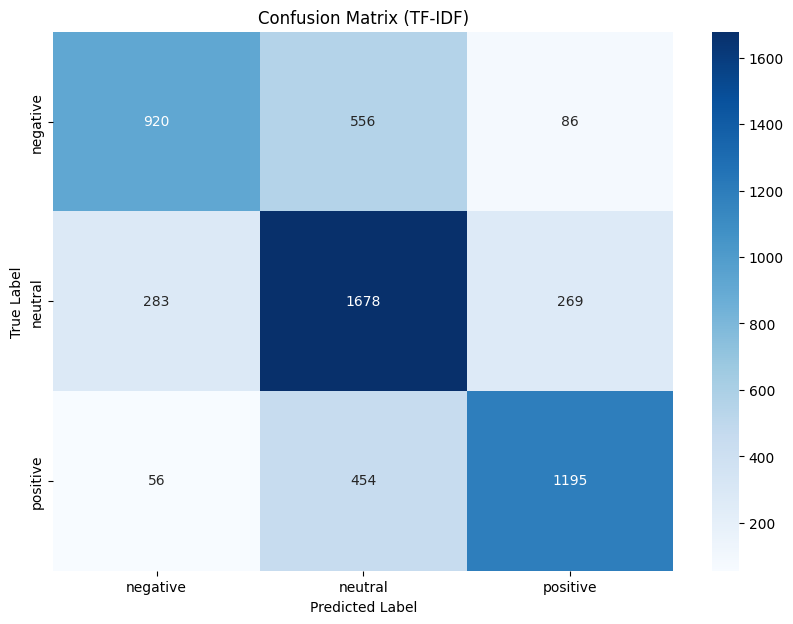

In [18]:
import pandas as pd
import numpy as np

# Check data types
print("Type of y_test:", type(y_test))
print("Type of y_pred:", type(y_pred))

# Check unique values
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in y_pred:", np.unique(y_pred))

# Convert to numeric labels if needed
y_test = pd.Series(y_test).astype('category').cat.codes
y_pred = pd.Series(y_pred).astype('category').cat.codes

# Check unique values after conversion
print("Unique values in y_test after conversion:", np.unique(y_test))
print("Unique values in y_pred after conversion:", np.unique(y_pred))

# Now build the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TF-IDF)')
plt.show()

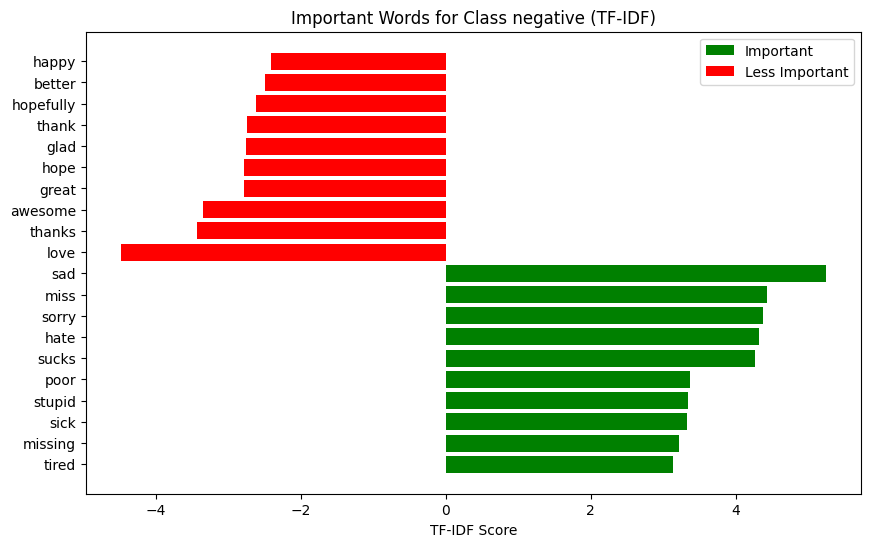

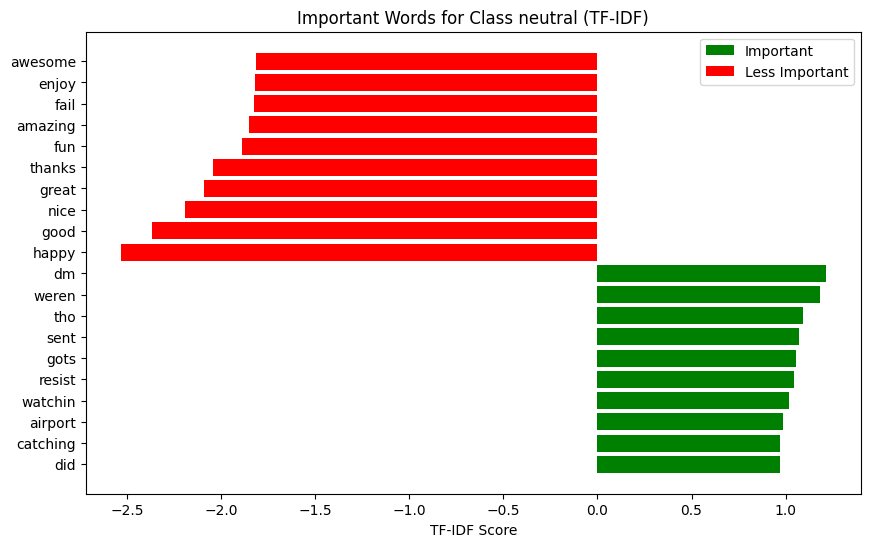

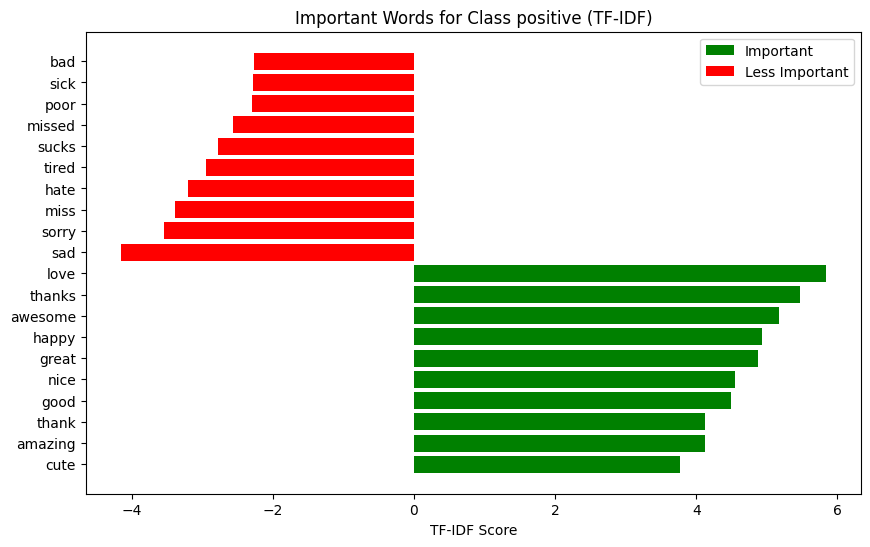

In [19]:
# Getting important words for each class
feature_names = tfidf_vectorizer.get_feature_names_out()
coef = model.coef_

for i, class_name in enumerate(['negative', 'neutral', 'positive']):
    top_indices = np.argsort(coef[i])[-10:]  # top-10 words
    bottom_indices = np.argsort(coef[i])[:10]  # least important top-10 words

    top_words = [feature_names[j] for j in top_indices]
    top_scores = coef[i][top_indices]

    bottom_words = [feature_names[j] for j in bottom_indices]
    bottom_scores = coef[i][bottom_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_scores, color='green', label='Important')
    plt.barh(bottom_words, bottom_scores, color='red', label='Less Important')
    plt.xlabel('TF-IDF Score')
    plt.title(f'Important Words for Class {class_name} (TF-IDF)')
    plt.legend()
    plt.show()
